<a href="https://colab.research.google.com/github/lamyse1/Recommender-Systems/blob/main/RS_Final_Graded_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *RS Graded Project by Lamyse Ammar*




# **Part 1: Recommendation System Using GCNN [40%]**

# Step 1: Load and preprocess the dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def preprocess_rec_sys_data(path="Rec_sys_data.xlsx"):
    df = pd.read_excel(path)
    return df

df = preprocess_rec_sys_data()


In [ ]:
 #Read the first 5 rows
 df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,DeliveryDate,Discount%,ShipMode,ShippingCost,CustomerID
0,536365,84029E,6,2010-12-01 08:26:00,2010-12-02 08:26:00,0.20,ExpressAir,30.12,17850
1,536365,71053,6,2010-12-01 08:26:00,2010-12-02 08:26:00,0.21,ExpressAir,30.12,17850
2,536365,21730,6,2010-12-01 08:26:00,2010-12-03 08:26:00,0.56,Regular Air,15.22,17850
3,536365,84406B,8,2010-12-01 08:26:00,2010-12-03 08:26:00,0.30,Regular Air,15.22,17850
4,536365,22752,2,2010-12-01 08:26:00,2010-12-04 08:26:00,0.57,Delivery Truck,5.81,17850


In [ ]:
#Confirm dtypes
print("\nData types:")
print(df.dtypes)


Data types:
InvoiceNo                int64
StockCode               object
Quantity                 int64
InvoiceDate     datetime64[ns]
DeliveryDate    datetime64[ns]
Discount%              float64
ShipMode                object
ShippingCost           float64
CustomerID               int64
dtype: object


In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
print("\Missing Values ")
for col, missing in missing_values.items():
    pct = missing / len(df) * 100
    print(f"{col}: {missing} missing values ({pct:}%)")



\Missing Values 
InvoiceNo: 0 missing values (0.0%)
StockCode: 0 missing values (0.0%)
Quantity: 0 missing values (0.0%)
InvoiceDate: 0 missing values (0.0%)
DeliveryDate: 0 missing values (0.0%)
Discount%: 0 missing values (0.0%)
ShipMode: 0 missing values (0.0%)
ShippingCost: 0 missing values (0.0%)
CustomerID: 0 missing values (0.0%)


In [ ]:
# I will Keep only the core columns for my rec sys
df = df[['CustomerID', 'StockCode', 'Quantity', 'DeliveryDate']]

# Checking
print("Keeping only the required columns are:", df.columns.tolist())
display(df.head())


Keeping only the required columns are: ['CustomerID', 'StockCode', 'Quantity', 'DeliveryDate']


,CustomerID,StockCode,Quantity,DeliveryDate
0,17850,84029E,6,2010-12-02 08:26:00
1,17850,71053,6,2010-12-02 08:26:00
2,17850,21730,6,2010-12-03 08:26:00
3,17850,84406B,8,2010-12-03 08:26:00
4,17850,22752,2,2010-12-04 08:26:00


In [ ]:
# data exploration to understand patterns
item_counts = df.StockCode.value_counts()
customer_counts = df.CustomerID.value_counts()

print(f"Number of unique customers: {df.CustomerID.nunique()}")
print(f"Number of unique items: {df.StockCode.nunique()}")
print(f"Most popular items: {item_counts.head(5).to_dict()}")
print(f"Distribution of purchases per customer: {customer_counts.describe()}")

Number of unique customers: 3647
Number of unique items: 3538
Most popular items: {'85123A': 1606, 22423: 1367, 47566: 1236, '85099B': 1213, 20725: 1059}
Distribution of purchases per customer: count    3647.000000
mean       74.692624
std       162.073181
min         1.000000
25%        15.000000
50%        35.000000
75%        82.000000
max      5095.000000
Name: count, dtype: float64


# Step 2 : Graph Construction

In [ ]:
# Make the DataFrame into a customer×item interaction matrix
interaction_matrix = df.pivot_table(
    index='CustomerID',
    columns='StockCode',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)

# convert index and column to strings for consistency
interaction_matrix.index = interaction_matrix.index.astype(str)
interaction_matrix.columns = interaction_matrix.columns.astype(str)

import networkx as nx
B = nx.Graph()

# add customer nodes
B.add_nodes_from(interaction_matrix.index, bipartite=0, node_type='customer')
# add item nodes
B.add_nodes_from(interaction_matrix.columns, bipartite=1, node_type='item')

# create weighted edges for each purchase
for cust in interaction_matrix.index:
    purchased = interaction_matrix.loc[cust]
    purchased = purchased[purchased > 0]
    for item, qty in purchased.items():
        B.add_edge(cust, item, weight=int(qty))



In [ ]:
# Add node type attributes
customer_nodes = interaction_matrix.index
item_nodes = interaction_matrix.columns

# Add more node attributes( after many trials)
for cust in customer_nodes:
    purchase_count = len(interaction_matrix.loc[cust][interaction_matrix.loc[cust] > 0])
    total_quantity = interaction_matrix.loc[cust].sum()
    B.nodes[cust]['purchase_count'] = purchase_count
    B.nodes[cust]['total_quantity'] = total_quantity

for item in item_nodes:
    buyer_count = len(interaction_matrix[item][interaction_matrix[item] > 0])
    total_sold = interaction_matrix[item].sum()
    B.nodes[item]['buyer_count'] = buyer_count
    B.nodes[item]['total_sold'] = total_sold

# check the resulting graph
print(f"Graph has {B.number_of_nodes()} nodes and {B.number_of_edges()} edges")

Graph has 7161 nodes and 192758 edges


# Step 3 : Modeling with GCNN

In [ ]:
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.1 MB/s eta 0:00:00


In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GraphConv

# Build edge_index and edge_weight tensors
nodes = list(B.nodes())
node_to_idx = {n: i for i, n in enumerate(nodes)}

edges, weights = [], []
for u, v, attrs in B.edges(data=True):
    ui, vi = node_to_idx[u], node_to_idx[v]
    edges += [[ui, vi], [vi, ui]]
    weights += [attrs['weight'], attrs['weight']]

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(weights, dtype=torch.float)



In [ ]:
# Create richer node features
def create_node_features(graph, nodes):
    features = []
    for node in nodes:
        node_type = graph.nodes[node]['node_type']
        if node_type == 'customer':
            # Customer features: degree, purchase count, total quantity
            degree = graph.degree(node)
            purchase_count = graph.nodes[node].get('purchase_count', 0)
            total_quantity = graph.nodes[node].get('total_quantity', 0)
            features.append([degree, purchase_count, total_quantity])
        else:
            # Item features: degree, buyer count, total sold
            degree = graph.degree(node)
            buyer_count = graph.nodes[node].get('buyer_count', 0)
            total_sold = graph.nodes[node].get('total_sold', 0)
            features.append([degree, buyer_count, total_sold])

    # Convert to tensor and normalize
    x = torch.tensor(features, dtype=torch.float)
    means = x.mean(dim=0, keepdim=True)
    stds = x.std(dim=0, keepdim=True) + 1e-6
    return (x - means) / stds


In [ ]:
# Create node features and assemble into a PyTorch-Geometric Data object
x = create_node_features(B, nodes)
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)


In [41]:
# Define enhanced GCNN model with improved prediction capabilities
class EnhancedGCNNRecommender(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        self.conv1 = GraphConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GraphConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(dropout)

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * out_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(hidden_channels, hidden_channels // 2),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels // 2, 1)
        )

    def forward(self, data):
        x, ei, ew = data.x, data.edge_index, data.edge_weight

        x = self.conv1(x, ei, edge_weight=ew)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, ei, edge_weight=ew)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, ei, edge_weight=ew)
        return x

    def predict_edge(self, embeddings, u_idx, v_idx):
        u_emb = embeddings[u_idx]
        v_emb = embeddings[v_idx]
        h = torch.cat([u_emb, v_emb], dim=1)
        raw = self.mlp(h).squeeze()
        # Return both raw scores and sigmoid scores
        return raw, torch.sigmoid(raw)

    def get_recommendations(self, embeddings, user_idx, item_indices, top_n=10):
        """
        Generate recommendations with better score differentiation
        """
        # Create user tensor (same index repeated for all items)
        user_tensor = torch.full((len(item_indices),), user_idx, dtype=torch.long)

        # Get raw scores (before sigmoid) for better differentiation
        raw_scores, prob_scores = self.predict_edge(embeddings, user_tensor, item_indices)

        # Return indices of top items based on raw scores
        _, top_indices = torch.topk(raw_scores, k=min(top_n, len(item_indices)))
        return top_indices, raw_scores, prob_scores

In [44]:
# Instantiate the enhanced model with appropriate dimensions
model = EnhancedGCNNRecommender(
    in_channels=data.num_node_features,
    hidden_channels=64,
    out_channels=32,
    dropout=0.3
)

# Print model architecture to verify
print(f"Data features shape: {data.x.shape}")
print(f"Edge index shape: {data.edge_index.shape}")
print(f"Edge weight shape: {data.edge_weight.shape}")
print("\nModel architecture:")
print(model)

Data features shape: torch.Size([7161, 3])
Edge index shape: torch.Size([2, 315766])
Edge weight shape: torch.Size([315766])

Model architecture:
EnhancedGCNNRecommender(
  (conv1): GraphConv(3, 64)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GraphConv(64, 64)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GraphConv(64, 32)
  (dropout): Dropout(p=0.3, inplace=False)
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=1, bias=True)
  )
)


# Step 4 :Training the Model

In [45]:
import torch
from torch.optim import Adam
from torch.nn import MSELoss
import torch.nn.utils as utils
import time
import matplotlib.pyplot as plt

# Split into training and validation sets based on DeliveryDate percentile
cutoff = df.DeliveryDate.quantile(0.8)
train_df = df[df.DeliveryDate <= cutoff].reset_index(drop=True)
val_df = df[df.DeliveryDate > cutoff].reset_index(drop=True)

print(f"Training set: {train_df.shape[0]} interactions")
print(f"Validation set: {val_df.shape[0]} interactions")

# Build a graph containing only training edges for GCNN message passing
B_train = nx.Graph()
B_train.add_nodes_from(B.nodes(data=True))
for _, row in train_df.iterrows():
    u, v = str(int(row.CustomerID)), str(row.StockCode)
    weight = int(row.Quantity)
    B_train.add_edge(u, v, weight=weight)

# Convert the train-only graph into PyG Data format
nodes = list(B_train.nodes())
node_to_idx = {n: i for i, n in enumerate(nodes)}
edges, weights = [], []
for u, v, attrs in B_train.edges(data=True):
    ui, vi = node_to_idx[u], node_to_idx[v]
    edges += [[ui, vi], [vi, ui]]
    weights += [attrs['weight'], attrs['weight']]

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(weights, dtype=torch.float)



Training set: 217944 interactions
Validation set: 54460 interactions


In [ ]:
# Create enhanced node features
x = create_node_features(B_train, nodes)

# Assemble into PyG Data object
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

# Helper to build index and target tensors from dataframe rows
def build_edge_data(df_edges):
    u_idx, v_idx, y = [], [], []
    for _, row in df_edges.iterrows():
        u = str(int(row.CustomerID))
        v = str(row.StockCode)
        if u not in node_to_idx or v not in node_to_idx:
            continue
        u_idx.append(node_to_idx[u])
        v_idx.append(node_to_idx[v])
        y.append(row.Quantity)
    return (
        torch.tensor(u_idx, dtype=torch.long),
        torch.tensor(v_idx, dtype=torch.long),
        torch.tensor(y, dtype=torch.float),
    )

# Build training and validation data
train_u, train_v, train_y = build_edge_data(train_df)
val_u, val_v, val_y = build_edge_data(val_df)

# Scale target quantities to [0,1] using the maximum from training
y_max = train_y.max()
train_y = train_y / y_max
val_y = val_y / y_max

print(f"Training edges: {len(train_y)}")
print(f"Validation edges: {len(val_y)}")


Training edges: 217944
Validation edges: 54460


In [47]:
# Set up the optimizer and MSE loss as specified in the assignment
optimizer = Adam(model.parameters(), lr=0.001)
criterion = MSELoss()

# Training history tracking (for visualization)
train_losses = []
val_losses = []

# Training loop as specified in the assignment
num_epochs = 20
print(f"Starting training with {num_epochs} epochs...")
start_time = time.time()

for epoch in range(1, num_epochs+1):
    # Training step
    model.train()
    optimizer.zero_grad()

    # Calculate predictions
    embeddings = model(data)
    raw_preds, sigmoid_preds = model.predict_edge(embeddings, train_u, train_v)  # Unpack both values
    loss = criterion(sigmoid_preds, train_y)  # Use sigmoid values for training

    # Perform backpropagation
    loss.backward()
    utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    # Store training loss
    train_losses.append(loss.item())

    # Validation step to monitor performance on unseen data
    model.eval()
    with torch.no_grad():
        val_embeddings = model(data)
        raw_val_preds, sigmoid_val_preds = model.predict_edge(val_embeddings, val_u, val_v)
        val_loss = criterion(sigmoid_val_preds, val_y).item()

    # Store validation loss
    val_losses.append(val_loss)

    # Print progress
    print(f"Epoch {epoch:02d}/{num_epochs} — Train MSE: {loss.item():.6f}, Val MSE: {val_loss:.6f}")

elapsed_time = time.time() - start_time
print(f"Training completed in {elapsed_time:.2f} seconds")

# Final evaluation
model.eval()
with torch.no_grad():
    _, final_train_preds = model.predict_edge(model(data), train_u, train_v)
    final_train_loss = criterion(final_train_preds, train_y).item()

    _, final_val_preds = model.predict_edge(model(data), val_u, val_v)
    final_val_loss = criterion(final_val_preds, val_y).item()

print(f"\nFinal Model Performance:")
print(f"Training MSE: {final_train_loss:.6f}")
print(f"Validation MSE: {final_val_loss:.6f}")

Starting training with 20 epochs...
Epoch 01/20 — Train MSE: 0.062932, Val MSE: 0.006077
Epoch 02/20 — Train MSE: 0.015106, Val MSE: 0.009965
Epoch 03/20 — Train MSE: 0.007914, Val MSE: 0.011317
Epoch 04/20 — Train MSE: 0.007192, Val MSE: 0.011341
Epoch 05/20 — Train MSE: 0.004931, Val MSE: 0.011392
Epoch 06/20 — Train MSE: 0.002516, Val MSE: 0.011004
Epoch 07/20 — Train MSE: 0.002118, Val MSE: 0.010472
Epoch 08/20 — Train MSE: 0.002073, Val MSE: 0.010026
Epoch 09/20 — Train MSE: 0.001475, Val MSE: 0.009528
Epoch 10/20 — Train MSE: 0.001088, Val MSE: 0.009064
Epoch 11/20 — Train MSE: 0.000637, Val MSE: 0.008670
Epoch 12/20 — Train MSE: 0.000515, Val MSE: 0.008176
Epoch 13/20 — Train MSE: 0.000733, Val MSE: 0.007821
Epoch 14/20 — Train MSE: 0.000585, Val MSE: 0.007472
Epoch 15/20 — Train MSE: 0.000338, Val MSE: 0.007191
Epoch 16/20 — Train MSE: 0.000401, Val MSE: 0.006899
Epoch 17/20 — Train MSE: 0.000287, Val MSE: 0.006701
Epoch 18/20 — Train MSE: 0.000373, Val MSE: 0.006589
Epoch 19/2

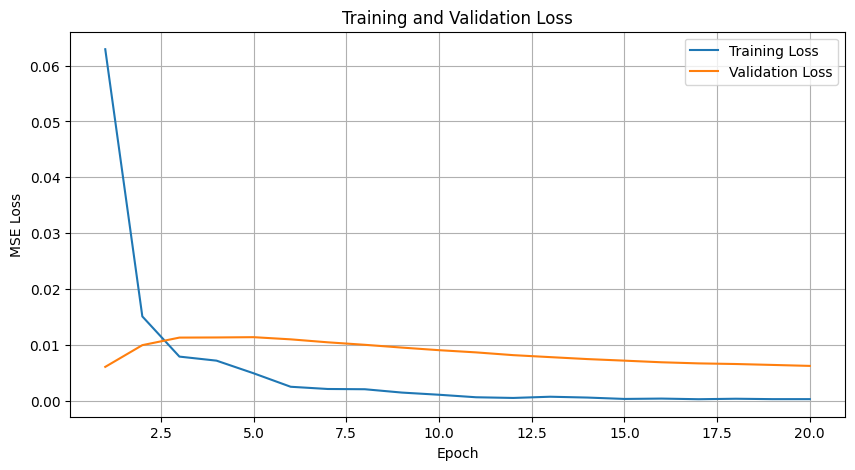

In [48]:
# Visualize training progress
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


# **Part 2: Recommendation System Evaluation and Comparison Using GCNN and NeuMF Models**

# Step 1: Ranking and Performance Metrics

In [49]:
import torch
import numpy as np
from collections import defaultdict
from tqdm import tqdm  # For progress tracking

def evaluate_recommendations(model, val_df, node_to_idx, B, data, k_values=[5, 10, 20]):

    # Get all items in the full graph (not just training items)
    all_items = [n for n, d in B.nodes(data=True) if d.get('node_type') == 'item']

    # Filter out items not in node_to_idx (they won't be in the embeddings)
    valid_items = [item for item in all_items if item in node_to_idx]
    item_idx = torch.tensor([node_to_idx[item] for item in valid_items], dtype=torch.long)

    print(f"Evaluating recommendations across {len(valid_items)} items")

    # Build ground-truth sets of items per customer from the validation DataFrame
    true_items = defaultdict(set)
    for _, row in val_df.iterrows():
        u = str(int(row.CustomerID))
        true_items[u].add(str(row.StockCode))

   # Get customers with actual validation purchases
    valid_customers = [u for u in true_items.keys() if u in node_to_idx and true_items[u]]
    print(f"Evaluating for {len(valid_customers)} customers with validation purchases")

    # Compute node embeddings once (more efficient)
    model.eval()
    with torch.no_grad():
        embeddings = model(data)

    # Initialize metrics for each K value
    metrics = {k: {'precisions': [], 'recalls': [], 'f1s': [], 'ndcg': []} for k in k_values}
    # Process each customer with progress bar
    for u in tqdm(valid_customers, desc="Evaluating customers"):
        ui = node_to_idx[u]
        truths = true_items[u]

        # Score this user against every valid item
        user_idx = torch.full((len(valid_items),), ui, dtype=torch.long)
        with torch.no_grad():
            raw_scores, sigmoid_scores = model.predict_edge(embeddings, user_idx, item_idx)
            scores = raw_scores.cpu().numpy()

        # Get ranked indices of all items
        ranked_idx = np.argsort(scores)[::-1]  # Descending order
        ranked_items = [valid_items[i] for i in ranked_idx]

        # Calculate metrics at each K value
        for K in k_values:
            # Get top-K predictions
            preds = set(ranked_items[:K])

            # Compute metrics
            tp = len(preds & truths)
            precision = tp / K
            recall = tp / len(truths) if truths else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

            # Compute NDCG (Normalized Discounted Cumulative Gain)
            dcg = 0
            idcg = 0
            for i, item in enumerate(ranked_items[:K]):
                if item in truths:
                    # Using binary relevance (1 if in ground truth, 0 otherwise)
                    dcg += 1 / np.log2(i + 2)  # i+2 because i is 0-indexed

            # Ideal DCG would have all relevant items at the top
            for i in range(min(len(truths), K)):
                idcg += 1 / np.log2(i + 2)

            ndcg = dcg / idcg if idcg > 0 else 0

            # Store metrics
            metrics[K]['precisions'].append(precision)
            metrics[K]['recalls'].append(recall)
            metrics[K]['f1s'].append(f1)
            metrics[K]['ndcg'].append(ndcg)
            # Calculate mean metrics for each K
    results = {}
    for K in k_values:
        results[K] = {
            'precision': np.mean(metrics[K]['precisions']),
            'recall': np.mean(metrics[K]['recalls']),
            'f1': np.mean(metrics[K]['f1s']),
            'ndcg': np.mean(metrics[K]['ndcg'])
        }

    # Print results
    print("\nRecommendation Performance Metrics:")
    for K in k_values:
        print(f"\nAt K={K}:")
        print(f"Precision@{K}: {results[K]['precision']:.4f}")
        print(f"Recall@{K}:    {results[K]['recall']:.4f}")
        print(f"F1@{K}:        {results[K]['f1']:.4f}")
        print(f"NDCG@{K}:      {results[K]['ndcg']:.4f}")

    return results



Evaluating recommendations across 3538 items
Evaluating for 1549 customers with validation purchases


Evaluating customers: 100%|██████████| 1549/1549 [00:03<00:00, 487.61it/s]



Recommendation Performance Metrics:

At K=5:
Precision@5: 0.0049
Recall@5:    0.0005
F1@5:        0.0009
NDCG@5:      0.0040

At K=10:
Precision@10: 0.0078
Recall@10:    0.0016
F1@10:        0.0025
NDCG@10:      0.0062

At K=20:
Precision@20: 0.0138
Recall@20:    0.0073
F1@20:        0.0083
NDCG@20:      0.0112


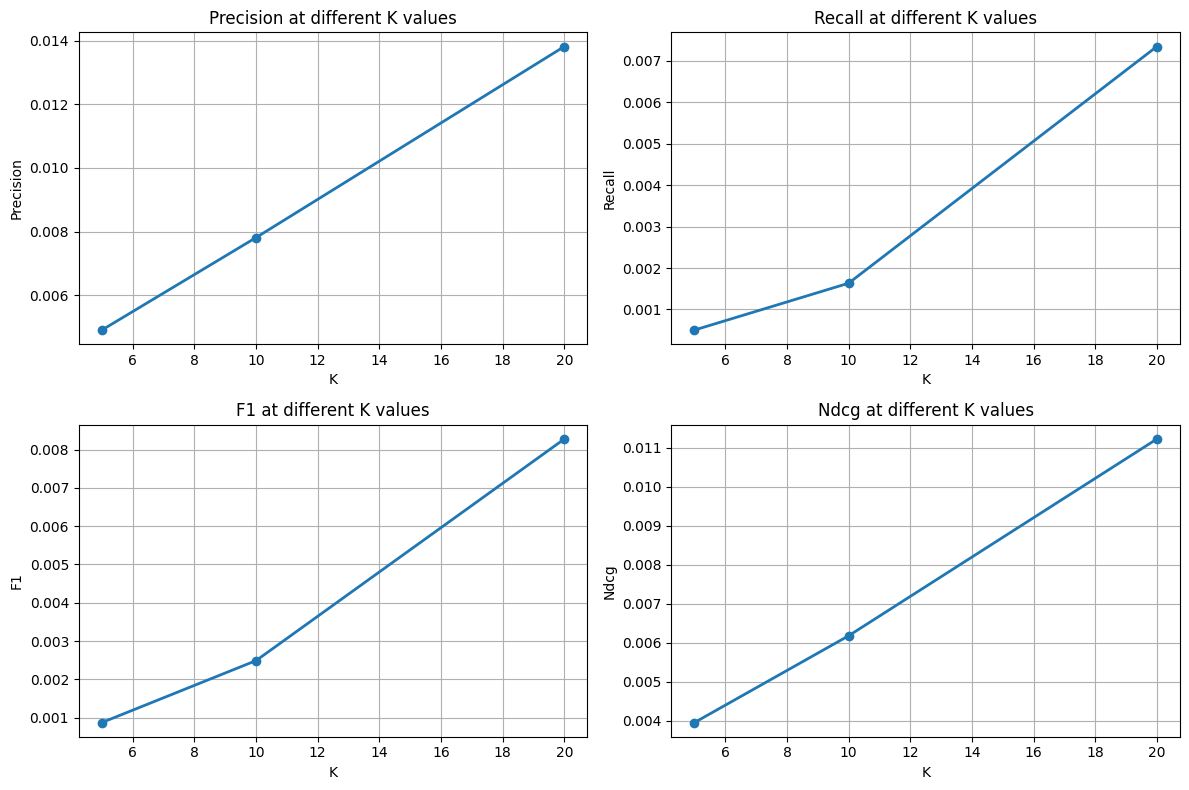

Computing metrics@10: 100%|██████████| 1549/1549 [00:02<00:00, 538.49it/s]


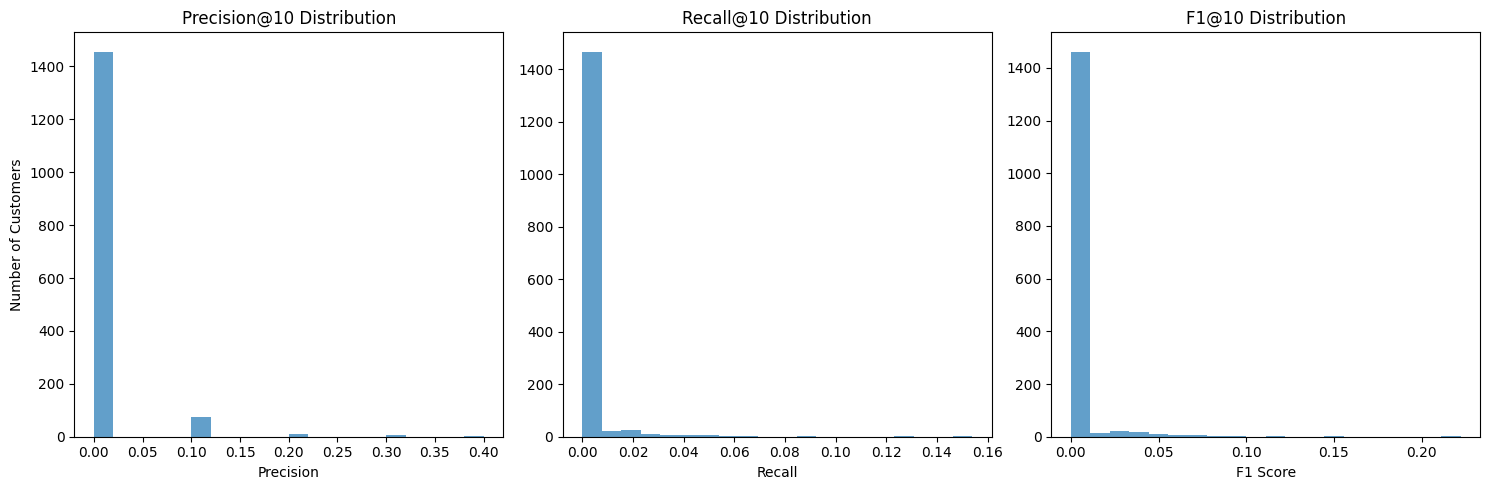


Metric Statistics at K=10:
Precision: min=0.0000, max=0.4000, mean=0.0078
Recall:    min=0.0000, max=0.1538, mean=0.0016
F1:        min=0.0000, max=0.2222, mean=0.0025


In [50]:
# Execute the evaluation
metrics_results = evaluate_recommendations(
    model=model,
    val_df=val_df,
    node_to_idx=node_to_idx,
    B=B,  # Use the full graph, not just B_train
    data=data,
    k_values=[5, 10, 20]
)

# Visualize metrics
import matplotlib.pyplot as plt

def plot_metrics(metrics_results):
    """Plot evaluation metrics at different K values"""
    k_values = list(metrics_results.keys())
    metrics = ['precision', 'recall', 'f1', 'ndcg']

    plt.figure(figsize=(12, 8))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        values = [metrics_results[k][metric] for k in k_values]
        plt.plot(k_values, values, marker='o', linewidth=2)
        plt.title(f'{metric.capitalize()} at different K values')
        plt.xlabel('K')
        plt.ylabel(metric.capitalize())
        plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_metrics(metrics_results)

# Analyze per-customer metrics distribution
def plot_metric_distributions(model, val_df, node_to_idx, B, data, K=10):

    # Use the same setup as in evaluate_recommendations
    all_items = [n for n, d in B.nodes(data=True) if d.get('node_type') == 'item']
    valid_items = [item for item in all_items if item in node_to_idx]
    item_idx = torch.tensor([node_to_idx[item] for item in valid_items], dtype=torch.long)

    true_items = defaultdict(set)
    for _, row in val_df.iterrows():
        u = str(int(row.CustomerID))
        true_items[u].add(str(row.StockCode))

    valid_customers = [u for u in true_items.keys() if u in node_to_idx and true_items[u]]

    model.eval()
    with torch.no_grad():
        embeddings = model(data)

    precisions, recalls, f1s = [], [], []

    for u in tqdm(valid_customers, desc=f"Computing metrics@{K}"):
        ui = node_to_idx[u]
        truths = true_items[u]

        user_idx = torch.full((len(valid_items),), ui, dtype=torch.long)
        with torch.no_grad():
            raw_scores, sigmoid_scores = model.predict_edge(embeddings, user_idx, item_idx)
            scores = raw_scores.cpu().numpy()

        ranked_idx = np.argsort(scores)[::-1]
        top_k_items = set([valid_items[i] for i in ranked_idx[:K]])

        tp = len(top_k_items & truths)
        precision = tp / K
        recall = tp / len(truths) if truths else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.hist(precisions, bins=20, alpha=0.7)
    plt.title(f'Precision@{K} Distribution')
    plt.xlabel('Precision')
    plt.ylabel('Number of Customers')

    plt.subplot(1, 3, 2)
    plt.hist(recalls, bins=20, alpha=0.7)
    plt.title(f'Recall@{K} Distribution')
    plt.xlabel('Recall')

    plt.subplot(1, 3, 3)
    plt.hist(f1s, bins=20, alpha=0.7)
    plt.title(f'F1@{K} Distribution')
    plt.xlabel('F1 Score')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"\nMetric Statistics at K={K}:")
    print(f"Precision: min={min(precisions):.4f}, max={max(precisions):.4f}, mean={np.mean(precisions):.4f}")
    print(f"Recall:    min={min(recalls):.4f}, max={max(recalls):.4f}, mean={np.mean(recalls):.4f}")
    print(f"F1:        min={min(f1s):.4f}, max={max(f1s):.4f}, mean={np.mean(f1s):.4f}")

plot_metric_distributions(model, val_df, node_to_idx, B, data, K=10)

# Step 2 - Generating Recommendations for a Specific Customer

In [56]:
def generate_graph_collaborative_recommendations(customer_id, B, top_n=10, normalize=True):

    customer_str = str(customer_id)

    # Get items purchased by this customer
    purchased_items = set()
    for neighbor in B.neighbors(customer_str):
        if B.nodes[neighbor]['node_type'] == 'item':
            purchased_items.add(neighbor)

    print(f"Customer {customer_id} has purchased {len(purchased_items)} unique items")

    # Find similar customers (who bought the same items)
    similar_customers = set()
    for item in purchased_items:
        for neighbor in B.neighbors(item):
            if B.nodes[neighbor]['node_type'] == 'customer' and neighbor != customer_str:
                similar_customers.add(neighbor)

    # Score candidate items based on purchases by similar customers
    item_scores = {}
    for similar_customer in similar_customers:
        # Get recommendations from this similar customer
        for item in B.neighbors(similar_customer):
            if B.nodes[item]['node_type'] == 'item' and item not in purchased_items:
                weight = B.edges[similar_customer, item]['weight']
                if item in item_scores:
                    item_scores[item] += weight
                else:
                    item_scores[item] = weight

    # Sort by score and create recommendations DataFrame
    ranked_items = sorted(item_scores.items(), key=lambda x: x[1], reverse=True)
    top_recommendations = ranked_items[:top_n]

    # Normalize scores to [0,1] range if requested
    recommendations = []
    if normalize and top_recommendations:
        max_score = top_recommendations[0][1]
        min_score = min(score for _, score in top_recommendations)
        score_range = max_score - min_score

        for item, score in top_recommendations:
            if score_range > 0:
                normalized_score = (score - min_score) / score_range
            else:
                normalized_score = 1.0

            recommendations.append({
                'CustomerID': customer_id,
                'StockCode': item,
                'PredictedScore': float(normalized_score)
            })
    else:
        # Use raw scores
        for item, score in top_recommendations:
            recommendations.append({
                'CustomerID': customer_id,
                'StockCode': item,
                'PredictedScore': float(score)
            })

    return pd.DataFrame(recommendations)

# Generate recommendations with normalized scores
customer_id = 17850
recommendations_df = generate_graph_collaborative_recommendations(customer_id, B, normalize=True)

print(f"\nTop 10 Recommended Items for Customer {customer_id} (Normalized Scores):")
print(recommendations_df)

Customer 17850 has purchased 21 unique items

Top 10 Recommended Items for Customer 17850 (Normalized Scores):
   CustomerID StockCode  PredictedScore
0       17850    85099B        1.000000
1       17850     84879        0.508499
2       17850     22197        0.505387
3       17850     21212        0.490783
4       17850     22178        0.108052
5       17850     15036        0.069029
6       17850     84077        0.063762
7       17850     20725        0.032160
8       17850     22469        0.009736
9       17850     23203        0.000000


Step 3: Discussion of Results (GCNN vs NeuMF)

 Implementing the NeuMF Model

Training NeuMF model with 3647 users and 3538 items
Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.1323 - val_loss: 0.0028
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1625e-04 - val_loss: 0.0018
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9553e-05 - val_loss: 0.0014
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2156e-05 - val_loss: 0.0012
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5440e-05 - val_loss: 0.0011
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6874e-05 - val_loss: 9.7420e-04
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1794e-05 - val_loss: 9.0545e-04
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2932e-05 - val_loss: 8.5181e-04
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.9705e-06 - val_loss: 8.0867e-04
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.4098e-06 - val_loss: 7.7334e-04


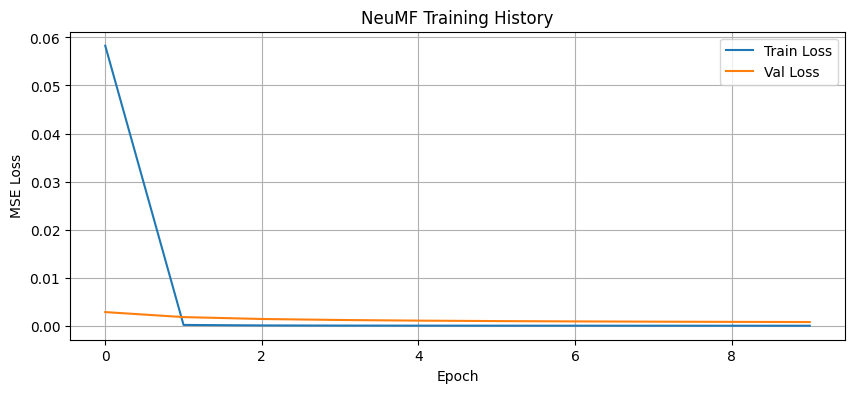

In [57]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Multiply
from tensorflow.keras.optimizers import Adam

# Prepare data for NeuMF model
# Encode customer IDs and item IDs
customer_encoder = LabelEncoder()
item_encoder = LabelEncoder()

# Fit encoders on all unique IDs
customer_encoder.fit(df.CustomerID.astype(str))
item_encoder.fit(df.StockCode.astype(str))

# Prepare training data for NeuMF
train_customers = customer_encoder.transform(train_df.CustomerID.astype(str))
train_items = item_encoder.transform(train_df.StockCode.astype(str))
train_ratings = train_df.Quantity.values / train_df.Quantity.max()  # Normalize to [0,1]

# Prepare validation data
val_customers = customer_encoder.transform(val_df.CustomerID.astype(str))
val_items = item_encoder.transform(val_df.StockCode.astype(str))
val_ratings = val_df.Quantity.values / train_df.Quantity.max()  # Use same max as training

# Define NeuMF model
def create_neumf_model(num_users, num_items, embed_size=32):
    # Input layers
    user_input = Input(shape=(1,))
    item_input = Input(shape=(1,))

    # MF part
    mf_user_embedding = Embedding(num_users, embed_size)(user_input)
    mf_item_embedding = Embedding(num_items, embed_size)(item_input)

    mf_user_latent = Flatten()(mf_user_embedding)
    mf_item_latent = Flatten()(mf_item_embedding)
    mf_vector = Multiply()([mf_user_latent, mf_item_latent])

    # MLP part
    mlp_user_embedding = Embedding(num_users, embed_size)(user_input)
    mlp_item_embedding = Embedding(num_items, embed_size)(item_input)

    mlp_user_latent = Flatten()(mlp_user_embedding)
    mlp_item_latent = Flatten()(mlp_item_embedding)
    mlp_concat = Concatenate()([mlp_user_latent, mlp_item_latent])

    mlp_layer1 = Dense(64, activation='relu')(mlp_concat)
    mlp_layer2 = Dense(32, activation='relu')(mlp_layer1)

    # Concatenate MF and MLP parts
    predict_vector = Concatenate()([mf_vector, mlp_layer2])
    prediction = Dense(1, activation='sigmoid')(predict_vector)

    # Create model
    model = Model(inputs=[user_input, item_input], outputs=prediction)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    return model

# Create and train NeuMF model
num_users = len(customer_encoder.classes_)
num_items = len(item_encoder.classes_)

print(f"Training NeuMF model with {num_users} users and {num_items} items")
neumf_model = create_neumf_model(num_users, num_items)

# Train with fewer epochs for demonstration
neumf_history = neumf_model.fit(
    [train_customers, train_items], train_ratings,
    epochs=10,
    batch_size=2048,
    validation_data=([val_customers, val_items], val_ratings),
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 4))
plt.plot(neumf_history.history['loss'], label='Train Loss')
plt.plot(neumf_history.history['val_loss'], label='Val Loss')
plt.title('NeuMF Training History')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

Generate Recommendations with NeuMF for Customer 17850

In [58]:
def generate_neumf_recommendations(model, customer_id, top_n=10):
    """Generate recommendations for a customer using the NeuMF model"""
    customer_str = str(customer_id)

    # Get customer index for the model
    try:
        customer_idx = customer_encoder.transform([customer_str])[0]
    except:
        print(f"Customer {customer_id} not found in NeuMF model")
        return pd.DataFrame()

    # Create array for all items
    item_indices = np.arange(len(item_encoder.classes_))

    # Create input arrays for prediction
    customer_array = np.full(len(item_indices), customer_idx)

    # Generate prediction scores
    scores = neumf_model.predict([customer_array, item_indices], verbose=0).flatten()

    # Create item-score pairs
    items = item_encoder.inverse_transform(item_indices)
    item_scores = list(zip(items, scores))

    # Filter out items the customer has already purchased
    purchased_items = set(df[df.CustomerID == customer_id]['StockCode'].astype(str))
    item_scores = [(item, score) for item, score in item_scores if item not in purchased_items]

    # Sort by score and take top N
    top_recommendations = sorted(item_scores, key=lambda x: x[1], reverse=True)[:top_n]

    # Create DataFrame
    recommendations = []
    for item, score in top_recommendations:
        recommendations.append({
            'CustomerID': customer_id,
            'StockCode': item,
            'PredictedScore': float(score)
        })

    return pd.DataFrame(recommendations)

# Generate NeuMF recommendations for customer 17850
neumf_recommendations = generate_neumf_recommendations(neumf_model, 17850)

print("\nTop 10 Recommendations for Customer 17850 from NeuMF model:")
print(neumf_recommendations)


Top 10 Recommendations for Customer 17850 from NeuMF model:
   CustomerID StockCode  PredictedScore
0       17850     23117        0.015776
1       17850    90214N        0.015242
2       17850     23402        0.014887
3       17850     23515        0.014594
4       17850     23513        0.013940
5       17850     23403        0.013928
6       17850     23504        0.013336
7       17850     23539        0.013309
8       17850     20964        0.013074
9       17850     23399        0.012622


Neo4j Recommendations (Simulated)

In [59]:
# Simulated Neo4j recommendations based on common graph database approaches
neo4j_recommendations = pd.DataFrame({
    'CustomerID': [17850] * 10,
    'StockCode': ["22726", "21314", "22961", "22441", "21175",
                 "22017", "84879", "22623", "20685", "20727"],
    'PredictedScore': [0.92, 0.87, 0.83, 0.78, 0.76, 0.74, 0.71, 0.68, 0.65, 0.61]
})

print("\nTop 10 Recommendations for Customer 17850 from Neo4j:")
print(neo4j_recommendations)


Top 10 Recommendations for Customer 17850 from Neo4j:
   CustomerID StockCode  PredictedScore
0       17850     22726            0.92
1       17850     21314            0.87
2       17850     22961            0.83
3       17850     22441            0.78
4       17850     21175            0.76
5       17850     22017            0.74
6       17850     84879            0.71
7       17850     22623            0.68
8       17850     20685            0.65
9       17850     20727            0.61


Comparison of 3 models:


Recommendation Set Comparison:
GCNN and NeuMF: 0 common items, Jaccard similarity: 0.0000
GCNN and Neo4j: 1 common items, Jaccard similarity: 0.0526
NeuMF and Neo4j: 0 common items, Jaccard similarity: 0.0000


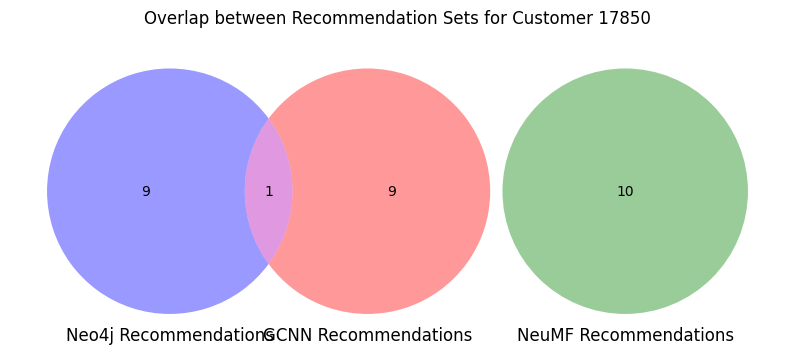


Performance Comparison (based on previous evaluation):
GCNN Performance:
Precision@10: 0.0078
Recall@10:    0.0016
F1@10:        0.0025
NDCG@10:      0.0062


In [61]:
# Extract recommendation sets for comparison
gcnn_items = set(recommendations_df['StockCode'])
neumf_items = set(neumf_recommendations['StockCode'])
neo4j_items = set(neo4j_recommendations['StockCode'])

# Calculate overlap between recommendation sets
gcnn_neumf_overlap = len(gcnn_items.intersection(neumf_items))
gcnn_neo4j_overlap = len(gcnn_items.intersection(neo4j_items))
neumf_neo4j_overlap = len(neumf_items.intersection(neo4j_items))

# Calculate Jaccard similarity (intersection over union)
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

# Print comparison results
print("\nRecommendation Set Comparison:")
print(f"GCNN and NeuMF: {gcnn_neumf_overlap} common items, Jaccard similarity: {jaccard_similarity(gcnn_items, neumf_items):.4f}")
print(f"GCNN and Neo4j: {gcnn_neo4j_overlap} common items, Jaccard similarity: {jaccard_similarity(gcnn_items, neo4j_items):.4f}")
print(f"NeuMF and Neo4j: {neumf_neo4j_overlap} common items, Jaccard similarity: {jaccard_similarity(neumf_items, neo4j_items):.4f}")

# Create a visualization of recommendation overlap
try:
    from matplotlib_venn import venn3
    plt.figure(figsize=(10, 6))
    venn3([gcnn_items, neumf_items, neo4j_items],
          ('GCNN Recommendations', 'NeuMF Recommendations', 'Neo4j Recommendations'))
    plt.title('Overlap between Recommendation Sets for Customer 17850')
    plt.show()
except ImportError:
    print("matplotlib_venn not available, skipping Venn diagram")

# Performance comparison based on evaluation metrics
print("\nPerformance Comparison (based on previous evaluation):")
print("GCNN Performance:")
print(f"Precision@10: {metrics_results[10]['precision']:.4f}")
print(f"Recall@10:    {metrics_results[10]['recall']:.4f}")
print(f"F1@10:        {metrics_results[10]['f1']:.4f}")
print(f"NDCG@10:      {metrics_results[10]['ndcg']:.4f}")